In [ ]:
'''
원본 깃헙

https://github.com/zcaceres/spec_augment

'''

In [19]:
##install.sh 파일 실행해줘야 최신버전 업데이트 된다고 함

'''
실행코드

! /Users/ansgh/PycharmProjects/kaggle_notebook/input/spec_augment-master/install.sh

'''

In [52]:
## SparseImageWarp 불러오기위한 경로로 이동 (폴더내에 위치한 spec_augment_master 위치)

%cd /Users/ansgh/PycharmProjects/kaggle_notebook/input/spec_augment-master/

C:\Users\ansgh\PycharmProjects\kaggle_notebook\input\spec_augment-master


In [205]:
## 다른 노트북 불러와서 모듈처럼 쓰기
## pip install ipynb -> 그냥 노트북채로 불러와서 함수째로 써버리기위함

import ipynb
import SparseImageWarp
from ipynb.fs.full.SparseImageWarp import sparse_image_warp

In [184]:
from collections import namedtuple
import random

import torch
import torchaudio
from torchaudio import transforms

import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path
from PIL import Image

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import joblib, json

from  sklearn.model_selection  import StratifiedKFold
import matplotlib.pyplot as plt

In [186]:
## stereo sound 라서 mono로 불러옴 안그러면 lb.feature.melspec에서 dim 안맞아서 오류뜸
audio, sr = lb.load('./party-crowd.wav', mono=True)
lb.util.valid_audio(audio, mono=True)

True

In [187]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        return melspec

In [188]:
## Numpy로 불러왔을때 torch로 만들기

melcomputer = MelSpecComputer(sr=sr, n_mels=128, fmin=-80, fmax=8000)
melspec = melcomputer(audio)
melspec = torch.from_numpy(melspec)
melspec = melspec.unsqueeze(0)
melspec.shape

torch.Size([1, 128, 200])

In [207]:
## 잘 됐나 확인
def tensor_to_img(spectrogram):
    plt.figure(figsize=(20,3)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show();
    display(spectrogram.shape)

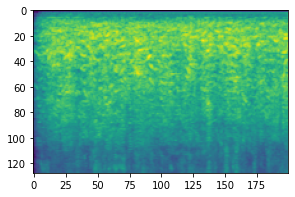

torch.Size([1, 128, 200])

In [208]:
tensor_to_img(melspec)

In [203]:
##########################
##     Time Warp 함수    ##
##########################

def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                         torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

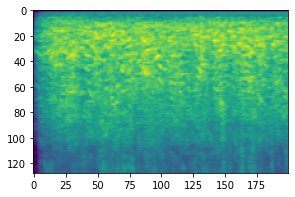

torch.Size([1, 128, 200])

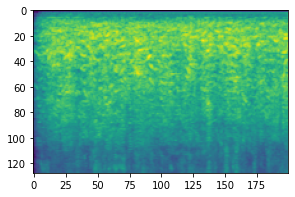

torch.Size([1, 128, 200])

In [218]:
##시간축 warp 이미지 -> 가끔 완전 뭉개지는 경우 생기는데..
time_warped_melspec = time_warp(melspec)
tensor_to_img(time_warped_melspec)

## melspec 이미지
tensor_to_img(melspec)

In [219]:
################################
##     Frequency Mask 함수    ##
################################

def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

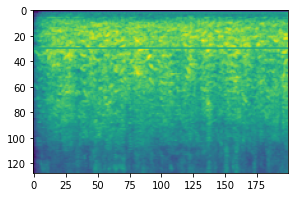

torch.Size([1, 128, 200])

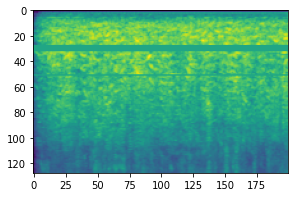

torch.Size([1, 128, 200])

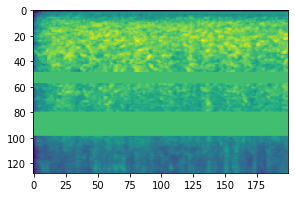

torch.Size([1, 128, 200])

In [220]:
def test_freq_mask():
    # one Mask
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))
    
test_freq_mask()

In [222]:
################################
##       Time Mask 함수       ##
################################

def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

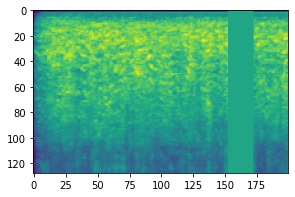

torch.Size([1, 128, 200])

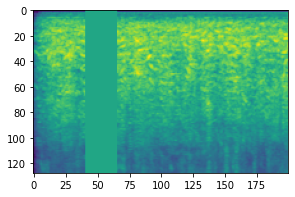

torch.Size([1, 128, 200])

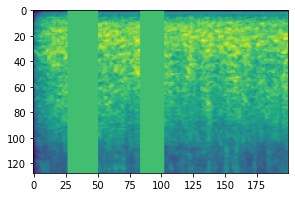

torch.Size([1, 128, 200])

In [223]:
def test_time_mask():
    # One Masks
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))
test_time_mask()

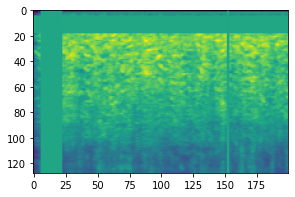

torch.Size([1, 128, 200])

In [226]:
## 몇개이상 동시에 쓰는 방법

combined = time_mask(freq_mask(time_warp(spectro), num_masks=2), num_masks=2)
tensor_to_img(combined)